# Applying DecisionTree on Donors Choose

# DonorsChoose

<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>

## About the DonorsChoose Data Set

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

### Notes on the Essay Data

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_4:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>


In [2]:
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sqlite3
import string
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import word2vec
from gensim.models import keyedvectors

from tqdm import tqdm
import os
import pickle
import re
from nltk.corpus import stopwords

import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

## Reading Data

In [3]:
project_data = pd.read_csv('train_data.csv', nrows=50000)
resource_data = pd.read_csv('resources.csv', nrows=50000)
project_data.shape

(50000, 17)

In [4]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

          project_subject_categories     project_subject_subcategories  \
0                Literacy & Language                     ESL, Literacy   
1  History & Civics, Health & Sports  Civics & Government, Team Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  
0                                             0                    0  
1                                             7                    1

In [5]:
resource_data.head(2)

id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

In [6]:
print(project_data.shape)
print(resource_data.shape)

(50000, 17)
(50000, 4)


In [7]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

id   price  quantity
0  p000027  782.13        15
1  p000052  114.98         2

In [8]:
# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')
project_data.shape

(50000, 19)

### preprocessing of project_subject_categories

In [9]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


### preprocessing of project_subject_subcategories

In [10]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

### Text preprocessing (Project_essay)

In [11]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [12]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  price  \
0                                             0                    0    NaN   
1                                             7                    1    NaN   

   quantity              clean_categories           clean_subcategories  \
0       NaN             Literacy_Language                  ESL Literacy   
1       NaN  History_Civics Health_Sports  Civics_Government TeamSports   

                                               essay  
0  My students are English learners that are work...  
1  Our students arrive to our school eager to lea...

In [13]:
# printing some random essays.
print(project_data['essay'].values[0])
print("="*50)
print(project_data['essay'].values[150])
print("="*50)
print(project_data['essay'].values[1000])
print("="*50)
print(project_data['essay'].values[2000])
print("="*50)
print(project_data['essay'].values[4999])
print("="*50)


My students are English learners that are working on English as their second or third languages. We are a melting pot of refugees, immigrants, and native-born Americans bringing the gift of language to our school. \r\n\r\n We have over 24 languages represented in our English Learner program with students at every level of mastery.  We also have over 40 countries represented with the families within our school.  Each student brings a wealth of knowledge and experiences to us that open our eyes to new cultures, beliefs, and respect.\"The limits of your language are the limits of your world.\"-Ludwig Wittgenstein  Our English learner's have a strong support system at home that begs for more resources.  Many times our parents are learning to read and speak English along side of their children.  Sometimes this creates barriers for parents to be able to help their child learn phonetics, letter recognition, and other reading skills.\r\n\r\nBy providing these dvd's and players, students are ab

In [14]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [15]:
sent = decontracted(project_data['essay'].values[2000])
print(sent)# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)
print("="*50)

Describing my students is not an easy task.  Many would say that they are inspirational, creative, and hard-working.  They are all unique - unique in their interests, their learning, their abilities, and so much more.  What they all have in common is their desire to learn each day, despite difficulties that they encounter.  \r\nOur classroom is amazing - because we understand that everyone learns at their own pace.  As the teacher, I pride myself in making sure my students are always engaged, motivated, and inspired to create their own learning! \r\nThis project is to help my students choose seating that is more appropriate for them, developmentally.  Many students tire of sitting in chairs during lessons, and having different seats available helps to keep them engaged and learning.\r\nFlexible seating is important in our classroom, as many of our students struggle with attention, focus, and engagement.  We currently have stability balls for seating, as well as regular chairs, but thes

In [16]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

Describing my students is not an easy task.  Many would say that they are inspirational, creative, and hard-working.  They are all unique - unique in their interests, their learning, their abilities, and so much more.  What they all have in common is their desire to learn each day, despite difficulties that they encounter.    Our classroom is amazing - because we understand that everyone learns at their own pace.  As the teacher, I pride myself in making sure my students are always engaged, motivated, and inspired to create their own learning!   This project is to help my students choose seating that is more appropriate for them, developmentally.  Many students tire of sitting in chairs during lessons, and having different seats available helps to keep them engaged and learning.  Flexible seating is important in our classroom, as many of our students struggle with attention, focus, and engagement.  We currently have stability balls for seating, as well as regular chairs, but these stoo

In [17]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

Describing my students is not an easy task Many would say that they are inspirational creative and hard working They are all unique unique in their interests their learning their abilities and so much more What they all have in common is their desire to learn each day despite difficulties that they encounter Our classroom is amazing because we understand that everyone learns at their own pace As the teacher I pride myself in making sure my students are always engaged motivated and inspired to create their own learning This project is to help my students choose seating that is more appropriate for them developmentally Many students tire of sitting in chairs during lessons and having different seats available helps to keep them engaged and learning Flexible seating is important in our classroom as many of our students struggle with attention focus and engagement We currently have stability balls for seating as well as regular chairs but these stools will help students who have trouble wi

In [18]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [19]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|███████████████████████████████████| 50000/50000 [00:52<00:00, 957.07it/s]


In [20]:
# after preprocesing
preprocessed_essays[2000]

'describing students not easy task many would say inspirational creative hard working unique unique interests learning abilities much common desire learn day despite difficulties encounter classroom amazing understand everyone learns pace teacher pride making sure students always engaged motivated inspired create learning project help students choose seating appropriate developmentally many students tire sitting chairs lessons different seats available helps keep engaged learning flexible seating important classroom many students struggle attention focus engagement currently stability balls seating well regular chairs stools help students trouble balance find difficult sit stability ball long period time excited try stools part engaging classroom community nannan'

### Preprocessing of project_title

In [21]:
sent_0=project_data["project_title"].values[11]
print(sent_0)
print("="*50)

sent_1000=project_data["project_title"].values[34]
print(sent_1000)
print("="*50)

sent_1500=project_data["project_title"].values[147]
print(sent_1500)
print("="*50)

sent_1500=project_data["project_title"].values[1277]
print(sent_1500)
print("="*50)


Elevating Academics and Parent Rapports Through Technology
\"Have A Ball!!!\"
Who needs a Chromebook?\r\nWE DO!!
Time Keeper=Empathy Builder


In [22]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [23]:
sent = decontracted(project_data['project_title'].values[34])
print(sent)
print("="*50)

\"Have A Ball!!!\"


In [24]:
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

 Have A Ball!!! 


In [25]:
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

 Have A Ball 


In [26]:
from tqdm import tqdm
preprocessed_title = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_title.append(sent.lower().strip())

100%|█████████████████████████████████| 50000/50000 [00:02<00:00, 21756.81it/s]


In [27]:
preprocessed_title[34]

'have a ball'

In [28]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  price  \
0                                             0                    0    NaN   
1                                             7                    1    NaN   

   quantity              clean_categories           clean_subcategories  \
0       NaN             Literacy_Language                  ESL Literacy   
1       NaN  History_Civics Health_Sports  Civics_Government TeamSports   

                                               essay  
0  My students are English learners that are work...  
1  Our students arrive to our school eager to lea...

### Adding a new feature Number of words in title

In [29]:
project_data['preprocessed_title']=preprocessed_title

In [30]:
title_word_count = []

In [31]:
for a in project_data["preprocessed_title"]:
    b = len(a.split())
    title_word_count.append(b)

In [32]:
project_data["title_word_count"] = title_word_count

In [33]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2  ...  \
0  \"The limits of your language are the limits o...  ...   
1  The projector we need for our school is very c...  ...   

                            project_resource_summary  \
0  My students need opportunities to practice beg...   
1  My students need a projector to help with view...   

  teacher_number_of_previously_posted_projects project_is_approved  price  \
0                                            0                   0    NaN   
1                                            7                   1    NaN   

   quantity              clean_categories           clean_subcategories  \
0       NaN             Literacy_Language                  ESL Literacy   
1       NaN  History_Civics Health_Sports  Civics_Government TeamSports   

                                               essay  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                          preprocessed_title title_word_count  
0  educational support english learners home                5  
1           wanted projector hungry learners                4  

[2 rows x 22 columns]

### Adding a new feature Number of words in essay

In [34]:
project_data['preprocessed_essays']=preprocessed_essays

In [35]:
essay_word_count=[]

In [36]:
for ess in project_data["preprocessed_essays"] :
    c = len(ess.split())
    essay_word_count.append(c)

In [37]:
project_data["essay_word_count"] = essay_word_count

In [38]:
print(project_data.shape)
project_data.head(2)

(50000, 24)


Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2  ... project_is_approved  \
0  \"The limits of your language are the limits o...  ...                   0   
1  The projector we need for our school is very c...  ...                   1   

  price quantity              clean_categories           clean_subcategories  \
0   NaN      NaN             Literacy_Language                  ESL Literacy   
1   NaN      NaN  History_Civics Health_Sports  Civics_Government TeamSports   

                                               essay  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                          preprocessed_title title_word_count  \
0  educational support english learners home                5   
1           wanted projector hungry learners                4   

                                 preprocessed_essays essay_word_count  
0  students english learners working english seco...              149  
1  students arrive school eager learn polite gene...               99  

[2 rows x 24 columns]

### Calculating sentiment scores of essay

In [39]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()


neg = []
pos = []
neu = []
compound = []

for a in tqdm(project_data["preprocessed_essays"]) :
    b = analyser.polarity_scores(a)['neg']
    c = analyser.polarity_scores(a)['pos']
    d = analyser.polarity_scores(a)['neu']
    e = analyser.polarity_scores(a)['compound']
    neg.append(b)
    pos.append(c)
    neu.append(d)
    compound.append(e)

100%|████████████████████████████████████| 50000/50000 [10:16<00:00, 81.16it/s]


In [40]:
project_data["pos"] = pos
project_data["neg"] = neg
project_data["neu"] = neu
project_data["compound"] = compound

In [41]:
y = project_data['project_is_approved'].values
X = project_data.drop(['project_is_approved'], axis=1)
print(X.shape)
print(y.shape)
X.head(1)

(50000, 27)
(50000,)


Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   

                                      project_title  \
0  Educational Support for English Learners at Home   

                                     project_essay_1  \
0  My students are English learners that are work...   

                                     project_essay_2  ... clean_subcategories  \
0  \"The limits of your language are the limits o...  ...        ESL Literacy   

                                               essay  \
0  My students are English learners that are work...   

                          preprocessed_title  title_word_count  \
0  educational support english learners home                 5   

                                 preprocessed_essays  essay_word_count    pos  \
0  students english learners working english seco...               149  0.154   

     neg    neu compound  
0  0.013  0.833   0.9694  

[1 rows x 27 columns]

### Splitting data into Train and cross validation(or test): Stratified Sampling

In [42]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

In [43]:
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

(22445, 27) (22445,)
(11055, 27) (11055,)
(16500, 27) (16500,)


### Preparing Data For Models

#### Make Data Model Ready: encoding numerical, categorical features

### Vectorizing categorical data

In [44]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer.transform(X_train['school_state'].values)
X_cv_state_ohe = vectorizer.transform(X_cv['school_state'].values)
X_test_state_ohe = vectorizer.transform(X_test['school_state'].values)


school_feat = vectorizer.get_feature_names()#for desicion tree

print("After vectorizations")
print(X_train_state_ohe.shape, y_train.shape)
print(X_cv_state_ohe.shape, y_cv.shape)
print(X_test_state_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(22445, 51) (22445,)
(11055, 51) (11055,)
(16500, 51) (16500,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


In [45]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values.astype('U')) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
#https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document
X_train_teacher_ohe = vectorizer.transform(X_train['teacher_prefix'].values.astype('U'))
X_cv_teacher_ohe = vectorizer.transform(X_cv['teacher_prefix'].values.astype('U'))
X_test_teacher_ohe = vectorizer.transform(X_test['teacher_prefix'].values.astype('U'))

teacher_feat = vectorizer.get_feature_names()#for desicion tree

print("After vectorizations")
print(X_train_teacher_ohe.shape, y_train.shape)
print(X_cv_teacher_ohe.shape, y_cv.shape)
print(X_test_teacher_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(22445, 5) (22445,)
(11055, 5) (11055,)
(16500, 5) (16500,)
['mr', 'mrs', 'ms', 'nan', 'teacher']


In [46]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values.astype('U')) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_cv_grade_ohe = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)

grade_feat = vectorizer.get_feature_names()#for desicion tree

print("After vectorizations")
print(X_train_grade_ohe.shape, y_train.shape)
print(X_cv_grade_ohe.shape, y_cv.shape)
print(X_test_grade_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(22445, 3) (22445,)
(11055, 3) (11055,)
(16500, 3) (16500,)
['12', 'grades', 'prek']


In [47]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_clean_categories_ohe = vectorizer.transform(X_train['clean_categories'].values)
X_cv_clean_categories_ohe = vectorizer.transform(X_cv['clean_categories'].values)
X_test_clean_categories_ohe = vectorizer.transform(X_test['clean_categories'].values)

cat_feat = vectorizer.get_feature_names()#for decision tree

print("After vectorizations")
print(X_train_clean_categories_ohe.shape , y_train.shape)
print(X_cv_clean_categories_ohe.shape , y_cv.shape)
print(X_test_clean_categories_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(22445, 9) (22445,)
(11055, 9) (11055,)
(16500, 9) (16500,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


In [48]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_clean_subcategories_ohe = vectorizer.transform(X_train['clean_subcategories'].values)
X_cv_clean_subcategories_ohe = vectorizer.transform(X_cv['clean_subcategories'].values)
X_test_clean_subcategories_ohe = vectorizer.transform(X_test['clean_subcategories'].values)

sub_cat_feat = vectorizer.get_feature_names()#for decision tree

print("After vectorizations")
print(X_train_clean_subcategories_ohe.shape , y_train.shape)
print(X_cv_clean_subcategories_ohe.shape , y_cv.shape)
print(X_test_clean_subcategories_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(22445, 30) (22445,)
(11055, 30) (11055,)
(16500, 30) (16500,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


### Bag of words on essay

In [49]:
vectorizer = CountVectorizer(min_df=10,ngram_range=(2,2), max_features=5000)
vectorizer.fit(X_train['essay'].values)# fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer.transform(X_train['essay'].values)
X_cv_essay_bow = vectorizer.transform(X_cv['essay'].values)
X_test_essay_bow = vectorizer.transform(X_test['essay'].values)

BOW_feat_essay = vectorizer.get_feature_names()#for decision tree

print('Bow on essay')
print(X_train_essay_bow.shape, y_train.shape)
print(X_cv_essay_bow.shape, y_cv.shape)
print(X_test_essay_bow.shape, y_test.shape)

print('-'*50)

Bow on essay
(22445, 5000) (22445,)
(11055, 5000) (11055,)
(16500, 5000) (16500,)
--------------------------------------------------


### TFIDF vectorizer on essays

In [50]:
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(2,2),max_features=5000)
vectorizer.fit(X_train['essay'].values)# fit has to happen only on train data
# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer.transform(X_train['essay'].values)
X_cv_essay_tfidf = vectorizer.transform(X_cv['essay'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['essay'].values)

TFIDF_feat_essay = vectorizer.get_feature_names()#for decision tree

print('Tfidf vectrizer on essay')
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_cv_essay_tfidf.shape, y_cv.shape)
print(X_test_essay_tfidf.shape, y_test.shape)

print('-'*50)

Tfidf vectrizer on essay
(22445, 5000) (22445,)
(11055, 5000) (11055,)
(16500, 5000) (16500,)
--------------------------------------------------


### Bag of words on project title

In [51]:
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train['project_title'].values)
X_train_title_bow = vectorizer.transform(X_train['project_title'].values)
X_cv_title_bow = vectorizer.transform(X_cv['project_title'].values)
X_test_title_bow= vectorizer.transform(X_test['project_title'].values)

BOW_feat_title = vectorizer.get_feature_names()#for decision tree

print('Bow on project title')
print(X_train_title_bow.shape, y_train.shape)
print(X_cv_title_bow.shape, y_cv.shape)
print(X_test_title_bow.shape, y_test.shape)
print('='*50)

Bow on project title
(22445, 2605) (22445,)
(11055, 2605) (11055,)
(16500, 2605) (16500,)


### TFIDF vectorizer on project title

In [52]:
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4),max_features=5000)
vectorizer.fit(X_train['project_title'].values)
X_train_title_tfidf = vectorizer.transform(X_train['project_title'].values)
X_cv_title_tfidf = vectorizer.transform(X_cv['project_title'].values)
X_test_title_tfidf = vectorizer.transform(X_test['project_title'].values)

TFIDF_feat_title = vectorizer.get_feature_names()

print('tfidf vectorizer on project title')
print(X_train_title_tfidf.shape, y_train.shape)
print(X_cv_title_tfidf.shape, y_cv.shape)
print(X_test_title_tfidf.shape, y_test.shape)
print('='*50)

tfidf vectorizer on project title
(22445, 2605) (22445,)
(11055, 2605) (11055,)
(16500, 2605) (16500,)


### Vectorizing Numerical features

### Vectorizing- teacher number of previously posted projects

In [53]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
X_train['teacher_number_of_previously_posted_projects'].fillna(X_train['teacher_number_of_previously_posted_projects'].mean())
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_tnopp_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_cv_tnopp_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_tnopp_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))


print("After vectorizations")
print(X_train_tnopp_norm.shape, y_train.shape)
print(X_cv_tnopp_norm.shape, y_cv.shape)
print(X_test_tnopp_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


### Vectorizing - price

In [54]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()


#https://datascience.stackexchange.com/questions/11928/valueerror-input-contains-nan-infinity-or-a-value-too-large-for-dtypefloat32
X_train['price'].fillna(X_train['price'].mean(), inplace=True)
X_cv['price'].fillna(X_cv['price'].mean(), inplace=True)
X_test['price'].fillna(X_test['price'].mean(), inplace=True)
normalizer.fit(X_train['price'].values.reshape(1,-1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


### Vectorizing quantity

In [55]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

X_train['quantity'].fillna(X_train['quantity'].mean(), inplace=True)
X_cv['quantity'].fillna(X_cv['quantity'].mean(), inplace=True)
X_test['quantity'].fillna(X_test['quantity'].mean(), inplace=True)
normalizer.fit(X_train['quantity'].values.reshape(1,-1))



X_train_quantity_norm = normalizer.transform(X_train['quantity'].values.reshape(-1,1))
X_cv_quantity_norm = normalizer.transform(X_cv['quantity'].values.reshape(-1,1))
X_test_quantity_norm = normalizer.transform(X_test['quantity'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_quantity_norm.shape, y_train.shape)
print(X_cv_quantity_norm.shape, y_cv.shape)
print(X_test_quantity_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


### Vectorizeing essay_word_count

In [56]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

X_train['essay_word_count'].fillna(X_train['essay_word_count'].mean())
normalizer.fit(X_train['essay_word_count'].values.reshape(1,-1))

X_train_ewcount_norm = normalizer.transform(X_train['essay_word_count'].values.reshape(-1,1))
X_cv_ewcount_norm = normalizer.transform(X_cv['essay_word_count'].values.reshape(-1,1))
X_test_ewcount_norm = normalizer.transform(X_test['essay_word_count'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_ewcount_norm.shape, y_train.shape)
print(X_cv_ewcount_norm.shape, y_cv.shape)
print(X_test_ewcount_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


### vectorizing title_word_count

In [57]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

X_train['title_word_count'].fillna(X_train['title_word_count'].mean())
normalizer.fit(X_train['essay_word_count'].values.reshape(1,-1))

X_train_twcount_norm = normalizer.transform(X_train['title_word_count'].values.reshape(-1,1))
X_cv_twcount_norm = normalizer.transform(X_cv['title_word_count'].values.reshape(-1,1))
X_test_twcount_norm = normalizer.transform(X_test['title_word_count'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_twcount_norm.shape, y_train.shape)
print(X_cv_twcount_norm.shape, y_cv.shape)
print(X_test_twcount_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


### Vectorizing sentiment Scores essay of negative

In [58]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

X_train['neg'].fillna(X_train['neg'].mean())
normalizer.fit(X_train['neg'].values.reshape(1,-1))

X_train_neg_norm = normalizer.transform(X_train['neg'].values.reshape(-1,1))
X_cv_neg_norm = normalizer.transform(X_cv['neg'].values.reshape(-1,1))
X_test_neg_norm = normalizer.transform(X_test['neg'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_neg_norm.shape, y_train.shape)
print(X_cv_neg_norm.shape, y_cv.shape)
print(X_test_neg_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


### Vectorizing sentiment Scores essay of positive

In [59]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

X_train['pos'].fillna(X_train['pos'].mean())
normalizer.fit(X_train['pos'].values.reshape(1,-1))

X_train_pos_norm = normalizer.transform(X_train['pos'].values.reshape(-1,1))
X_cv_pos_norm = normalizer.transform(X_cv['pos'].values.reshape(-1,1))
X_test_pos_norm = normalizer.transform(X_test['pos'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_pos_norm.shape, y_train.shape)
print(X_cv_pos_norm.shape, y_cv.shape)
print(X_test_pos_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


### Vectorizing sentiment Scores essay of neutral

In [60]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

X_train['neu'].fillna(X_train['neu'].mean())
normalizer.fit(X_train['neu'].values.reshape(1,-1))

X_train_neu_norm = normalizer.transform(X_train['neu'].values.reshape(-1,1))
X_cv_neu_norm = normalizer.transform(X_cv['neu'].values.reshape(-1,1))
X_test_neu_norm = normalizer.transform(X_test['neu'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_neu_norm.shape, y_train.shape)
print(X_cv_neu_norm.shape, y_cv.shape)
print(X_test_neu_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


### Vectorizing sentiment Scores essay of compound

In [61]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

X_train['compound'].fillna(X_train['compound'].mean())
normalizer.fit(X_train['compound'].values.reshape(1,-1))

X_train_compound_norm = normalizer.transform(X_train['compound'].values.reshape(-1,1))
X_cv_compound_norm = normalizer.transform(X_cv['compound'].values.reshape(-1,1))
X_test_compound_norm = normalizer.transform(X_test['compound'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_compound_norm.shape, y_train.shape)
print(X_cv_compound_norm.shape, y_cv.shape)
print(X_test_compound_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


### Merging all the above

### categorical features

In [62]:
# merging all the categorical features
from scipy.sparse import hstack
categorical_tr=hstack((X_train_state_ohe,X_train_teacher_ohe,X_train_grade_ohe,X_train_clean_categories_ohe,
                       X_train_clean_subcategories_ohe))

categorical_cv=hstack((X_cv_state_ohe,X_cv_teacher_ohe,X_cv_grade_ohe,X_cv_clean_categories_ohe,
                       X_cv_clean_subcategories_ohe))

categorical_test=hstack((X_test_state_ohe,X_test_teacher_ohe,X_test_grade_ohe,X_test_clean_categories_ohe,
                         X_test_clean_subcategories_ohe))

print('='*50)

print('final datamatrix')
print(categorical_tr.shape,  y_train.shape)
print(categorical_cv.shape,  y_cv.shape)
print(categorical_test.shape, y_test.shape)

final datamatrix
(22445, 98) (22445,)
(11055, 98) (11055,)
(16500, 98) (16500,)


### numerical features

In [63]:
# merging all the numerical features
import scipy as sp
numerical_tr=sp.hstack((X_train_tnopp_norm,X_train_price_norm,X_train_quantity_norm,X_train_ewcount_norm,X_train_twcount_norm,
                        X_train_neg_norm,X_train_neu_norm,X_train_pos_norm,X_train_compound_norm))

numerical_cv=sp.hstack((X_cv_tnopp_norm,X_cv_price_norm,X_cv_quantity_norm, X_cv_ewcount_norm, X_cv_twcount_norm, X_cv_neg_norm,
                       X_cv_pos_norm, X_cv_neu_norm, X_cv_compound_norm))

numerical_test=sp.hstack((X_test_tnopp_norm,X_test_price_norm,X_test_quantity_norm, X_test_ewcount_norm, X_test_twcount_norm,
                         X_test_pos_norm,X_test_neg_norm, X_test_compound_norm,X_test_neu_norm))

print('='*100)

print('final matrix')
print(numerical_tr.shape, y_train.shape)
print(numerical_cv.shape, y_cv.shape)
print(numerical_test.shape, y_test.shape)

final matrix
(22445, 9) (22445,)
(11055, 9) (11055,)
(16500, 9) (16500,)


### Applying DT on categorical+numerical features + project_title(TFIDF)+ preprocessed_eassay (TFIDF)

In [64]:
#  creating the matrix 
x_tr_tfidf=hstack((categorical_tr,numerical_tr,X_train_essay_tfidf,X_train_title_tfidf)).tocsr()
x_cv_tfidf=hstack((categorical_cv,numerical_cv,X_cv_essay_tfidf,X_cv_title_tfidf)).tocsr()
x_test_tfidf=hstack((categorical_test,numerical_test,X_test_essay_tfidf,X_test_title_tfidf)).tocsr()

print('final matrix')
print(x_tr_tfidf.shape,   y_train.shape)
print(x_cv_tfidf.shape,   y_cv.shape)
print(x_test_tfidf.shape, y_test.shape)

final matrix
(22445, 7712) (22445,)
(11055, 7712) (11055,)
(16500, 7712) (16500,)


###  DECISION TREE 

In [77]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree
from sklearn.datasets import make_classification

clf=tree.DecisionTreeClassifier(class_weight = 'balanced')

parameters= {'max_depth': [1, 5, 10, 50,100,500], 'min_samples_split': [5, 10, 25, 50,100, 500]}
sd = GridSearchCV(clf, parameters, cv=5, scoring='roc_auc',return_train_score=True)
sd.fit(x_tr_tfidf, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [1, 5, 10, 50, 100, 500], 'min_samples_split': [5, 10, 25, 50, 100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

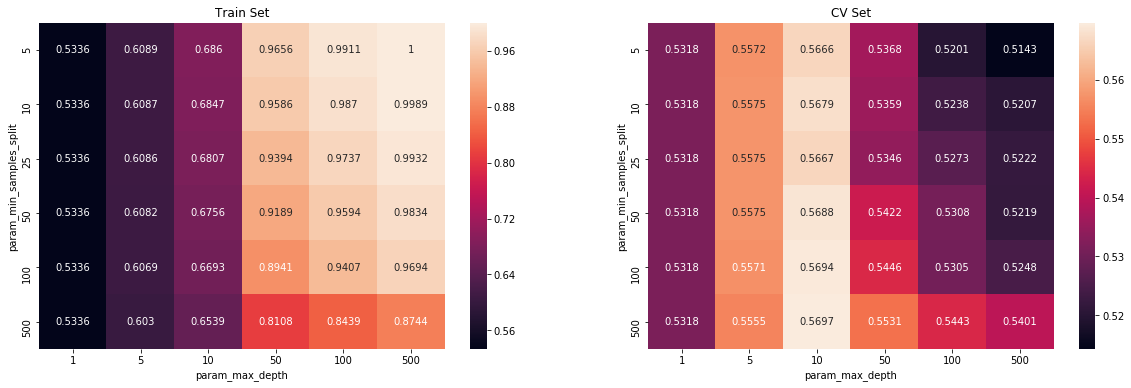

In [66]:
from sklearn.model_selection import GridSearchCV
max_scores = pd.DataFrame(sd.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]

fig, ax = plt.subplots(1,2, figsize=(20,6))

sns.heatmap(max_scores.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores.mean_test_score, annot = True, fmt='.4g', ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('CV Set')

plt.show()

#### HyperParameter tuning

#### Grid search

In [82]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

### max_depth

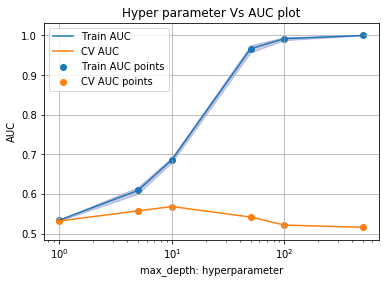

In [68]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import GridSearchCV

from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

clf=tree.DecisionTreeClassifier(class_weight = 'balanced')

parameters= {'max_depth': [1, 5, 10, 50,100, 500]}
sd = GridSearchCV(clf, parameters, cv=5, scoring='roc_auc',return_train_score=True)
sd.fit(x_tr_tfidf, y_train)


train_auc= sd.cv_results_['mean_train_score']
train_auc_std= sd.cv_results_['std_train_score']
cv_auc = sd.cv_results_['mean_test_score'] 
cv_auc_std= sd.cv_results_['std_test_score']

plt.plot(parameters['max_depth'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['max_depth'], train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters['max_depth'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters['max_depth'], train_auc, label='Train AUC points')
plt.scatter(parameters['max_depth'], cv_auc, label='CV AUC points')
plt.xscale('log')


plt.legend()
plt.xlabel("max_depth: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()


### min_samples_split

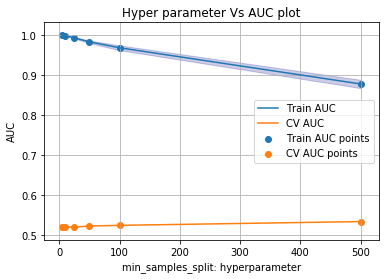

In [69]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

clf=tree.DecisionTreeClassifier(class_weight = 'balanced')

parameters= {'min_samples_split': [5, 10,25, 50, 100, 500]}
sd = GridSearchCV(clf, parameters, cv=5, scoring='roc_auc',return_train_score=True)
sd.fit(x_tr_tfidf, y_train)


train_auc= sd.cv_results_['mean_train_score']
train_auc_std= sd.cv_results_['std_train_score']
cv_auc = sd.cv_results_['mean_test_score'] 
cv_auc_std= sd.cv_results_['std_test_score']

plt.plot(parameters['min_samples_split'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['min_samples_split'], train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters['min_samples_split'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters['min_samples_split'], train_auc, label='Train AUC points')
plt.scatter(parameters['min_samples_split'], cv_auc, label='CV AUC points')



plt.legend()
plt.xlabel("min_samples_split: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()


### Testing the performance of the model on test data, plotting ROC Curves

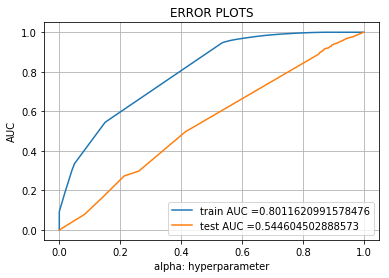

In [70]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


dt = tree.DecisionTreeClassifier(max_depth=50, min_samples_split=  100)
dt.fit(x_tr_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(dt, x_tr_tfidf)    
y_test_pred = batch_predict(dt, x_test_tfidf)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

### plotting confusion matrix

In [83]:
# we are writing our own function for predict, with defined threshold
# we will pick a threshold that will give the least fpr (False Positive Rate)
def predict(proba, threshold, fpr, tpr):
    
    t = threshold[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

#### Confusion matrix for train

In [72]:
## TRAIN
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.24898183169647298 for threshold 0.851
[[ 1621  1842]
 [ 1075 17907]]


In [73]:
conf_matr_df_train = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds,train_fpr, train_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.24898183169647298 for threshold 0.851


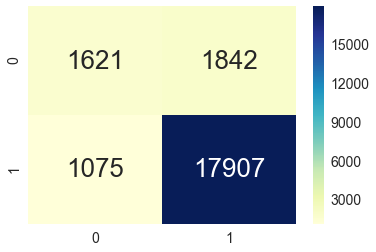

In [74]:
## Heatmaps -> https://likegeeks.com/seaborn-heatmap-tutorial/
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train, annot=True,annot_kws={"size": 26}, fmt='g',cmap="YlGnBu")

#### Confusion matrix for test

In [75]:
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24407354018348332 for threshold 0.871
[[1469 1077]
 [6917 7037]]


the maximum value of tpr*(1-fpr) 0.24407354018348332 for threshold 0.871


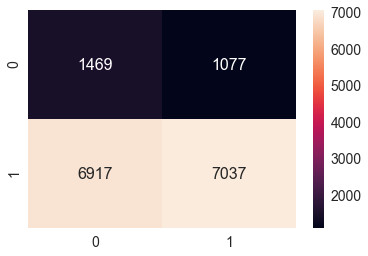

In [76]:
conf_matr_df_test = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test, annot=True,annot_kws={"size": 16}, fmt='g')

### Tree visualization

In [77]:
#merging all the categorical and tfidf features

TFIDF_feature = cat_feat + sub_cat_feat + grade_feat + school_feat + teacher_feat + TFIDF_feat_essay + TFIDF_feat_title


TFIDF_feature.append('price')
TFIDF_feature.append('teacher_number_of_previously_posted_projects')
TFIDF_feature.append('quantity')
TFIDF_feature.append('essay_word_count')
TFIDF_feature.append('title_word_count')
TFIDF_feature.append('neg')
TFIDF_feature.append('pos')
TFIDF_feature.append('neu')
TFIDF_feature.append('compound')
len(TFIDF_feature)


7752

### Tfidf tree visualization

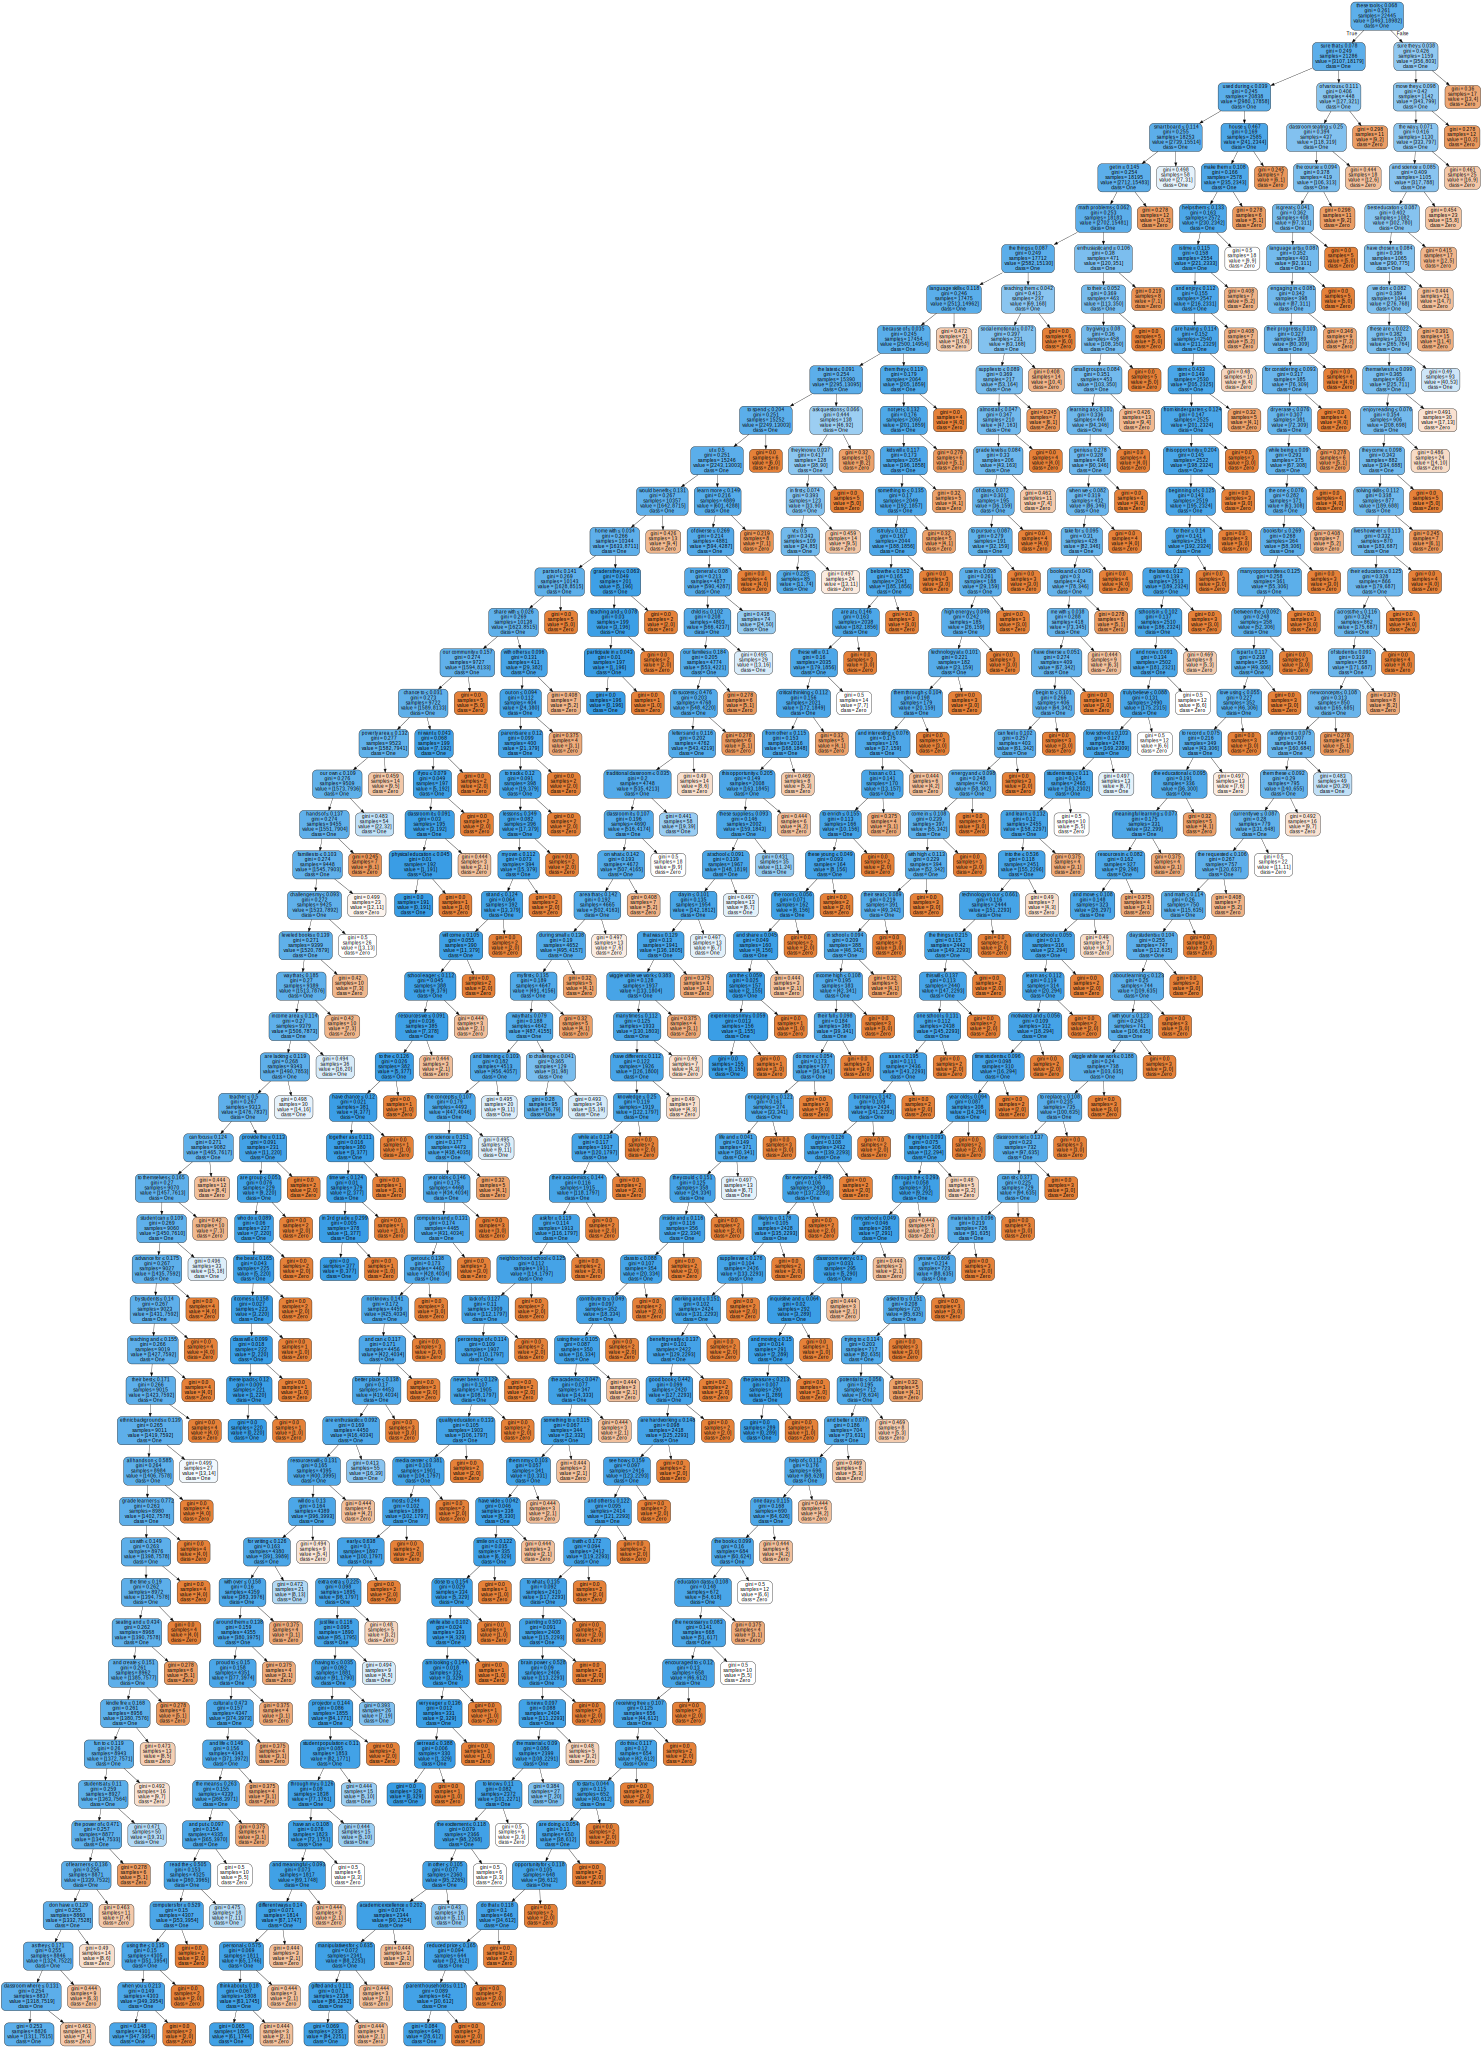

In [78]:
#https:https://scikit-learn.org/stable/modules/tree.html
import graphviz
data = tree.export_graphviz( dt, out_file=None, feature_names =TFIDF_feature  ,  class_names=['Zero', 'One'],
                                filled=True, rounded=True,  special_characters=True )  

graph = graphviz.Source(data)  

graph

### False positive points

In [79]:
print( len( y_test_pred ) )
ytest = list( y_test )
len( ytest )

16500


16500

In [80]:
# Claculating indexes of False Positive points
ind = []
for i in range( 0, 5000 ):
    
    if y_test_pred[i] == 0 and ytest[i] == 1:
        
        ind.append(i)

In [81]:
print( ind )
len( ind )

[115, 161, 252, 280, 389, 563, 621, 751, 755, 869, 944, 1229, 1231, 1272, 1277, 1286, 1321, 1349, 1448, 1616, 1620, 1641, 1671, 1712, 1877, 2236, 2255, 2311, 2391, 2518, 2601, 2667, 2759, 2762, 2828, 2860, 2865, 2964, 2987, 2997, 3038, 3162, 3234, 3390, 3538, 3583, 3612, 3717, 3727, 3870, 3927, 4233, 4237, 4304, 4426, 4464, 4515, 4635, 4704, 4713, 4720, 4741, 4783, 4825, 4827, 4871, 4890]


67

In [82]:
essay = ""
for i in ind:
    temp = project_data['essay'][i]
    essay += temp


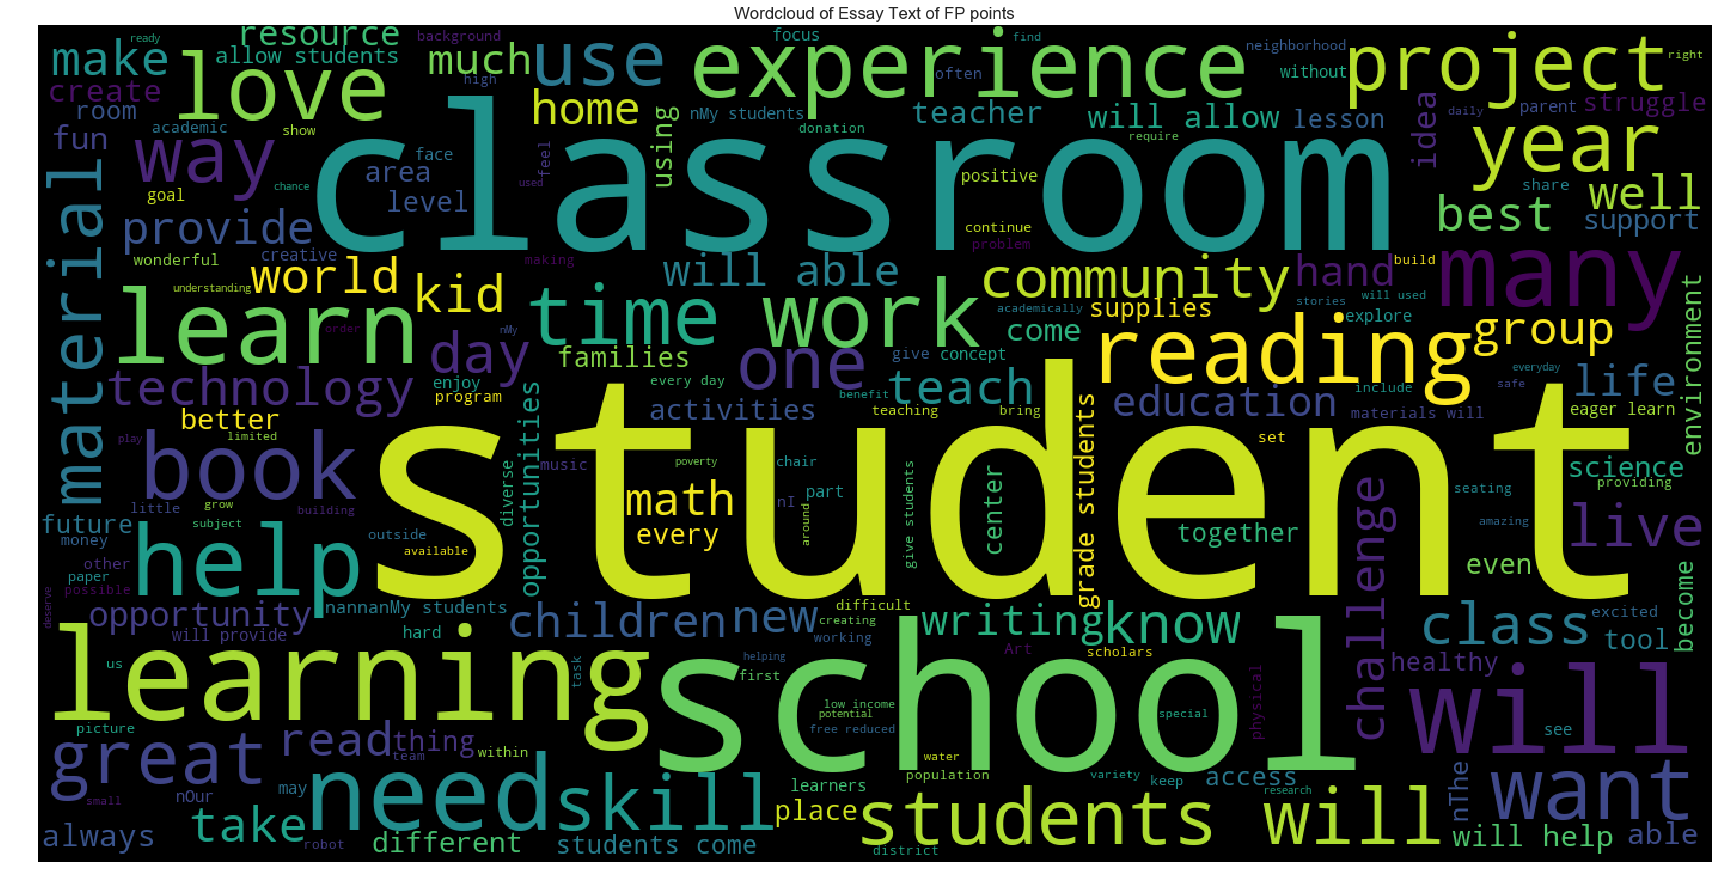

In [83]:
from wordcloud import WordCloud

# Create and generate a word cloud image:
wordcloud = WordCloud( background_color='black', width=1400, height=700 ).generate( essay )

# Display the generated image:
fig = plt.figure( figsize=(30,25) )
plt.imshow( wordcloud )
plt.title('Wordcloud of Essay Text of FP points')
plt.axis('off')
plt.show()

### box plot of price of false postive data points

In [84]:
# appending price feat with false positive indexes
price = []

for i in ind:
    price.append( project_data['price'][i] )

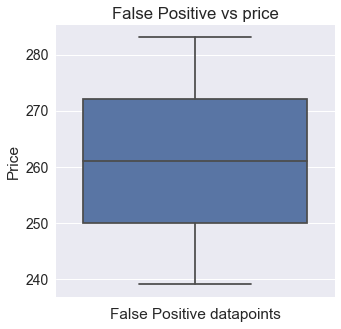

In [85]:
import seaborn as sns

plt.figure( figsize =(5,5) )
#plt.plot( ind, price )
sns.boxplot( y = price )
plt.xlabel('False Positive datapoints')
plt.ylabel('Price')
plt.title('False Positive vs price')
plt.show()


### pdf of teacher_number_of_previously_posted_projects 'false positive data points'

In [86]:
tnopp = []

for i in ind:
    tnopp.append( project_data['teacher_number_of_previously_posted_projects'][i] )

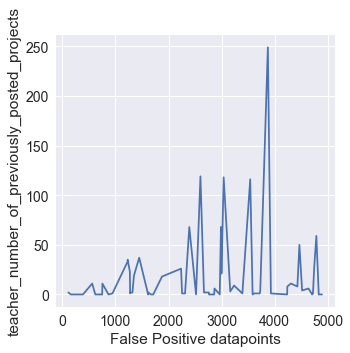

In [87]:
plt.figure( figsize =(5,5) )

plt.plot( ind, tnopp )

plt.xlabel('False Positive datapoints')
plt.ylabel('teacher_number_of_previously_posted_projects')

plt.show()

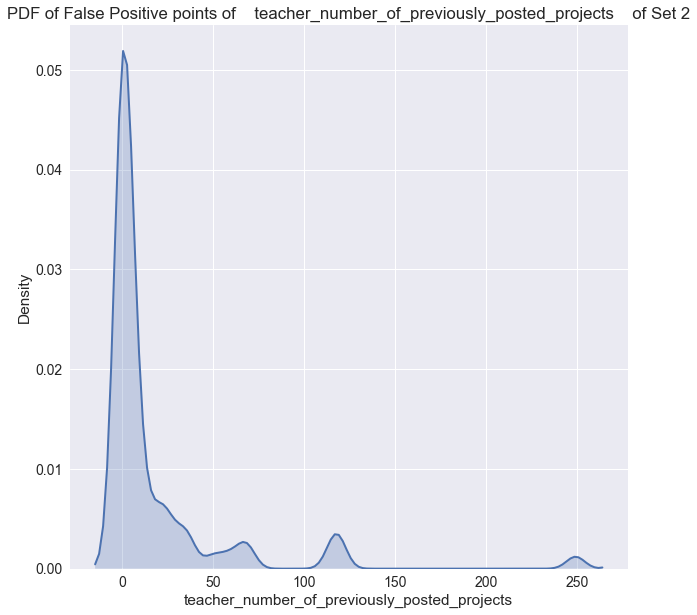

In [89]:
plt.figure( figsize =(10,10) )

sns.distplot( tnopp, hist = False, kde = True, kde_kws ={ 'linewidth' : 2, 'shade' : True } )

plt.title('PDF of False Positive points of    teacher_number_of_previously_posted_projects    of Set 2')
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.ylabel('Density')
plt.show()

### Applying Decssion Tree on categorical+numerical features + preprocessed_eassay (TFIDF W2V)+project_title(TFIDFW2V)

### TFIDF weighted W2V on essay

In [65]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [66]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['preprocessed_essays'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [68]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['preprocessed_essays']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_tr.append(vector)

print(len(tfidf_w2v_vectors_tr))
print(len(tfidf_w2v_vectors_tr[0]))

100%|███████████████████████████████████| 22445/22445 [01:30<00:00, 247.54it/s]

22445
300


In [69]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['preprocessed_essays']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_cv.append(vector)

print(len(tfidf_w2v_vectors_cv))
print(len(tfidf_w2v_vectors_cv[0]))

100%|███████████████████████████████████| 11055/11055 [00:43<00:00, 252.35it/s]

11055
300


In [70]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['preprocessed_essays']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test.append(vector)

print(len(tfidf_w2v_vectors_test))
print(len(tfidf_w2v_vectors_test[0]))

100%|███████████████████████████████████| 16500/16500 [01:04<00:00, 254.00it/s]

16500
300


### TFIDF weighted W2V on title

In [71]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['preprocessed_title'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [72]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors_tr_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['preprocessed_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_tr_title.append(vector)

print(len(tfidf_w2v_vectors_tr_title))
print(len(tfidf_w2v_vectors_tr_title[0]))

100%|█████████████████████████████████| 22445/22445 [00:01<00:00, 12723.19it/s]

22445
300


In [73]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors_cv_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['preprocessed_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_cv_title.append(vector)

print(len(tfidf_w2v_vectors_cv_title))
print(len(tfidf_w2v_vectors_cv_title[0]))

100%|█████████████████████████████████| 11055/11055 [00:00<00:00, 12662.51it/s]

11055
300


In [74]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors_test_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['preprocessed_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test_title.append(vector)

print(len(tfidf_w2v_vectors_test_title))
print(len(tfidf_w2v_vectors_test_title[0]))

100%|█████████████████████████████████| 16500/16500 [00:01<00:00, 12839.73it/s]

16500
300


In [75]:
x_tr_tfidf_w2v=hstack((categorical_tr,numerical_tr,tfidf_w2v_vectors_tr,tfidf_w2v_vectors_tr_title)).tocsr()
x_cv_tfidf_w2v=hstack((categorical_cv,numerical_cv,tfidf_w2v_vectors_cv,tfidf_w2v_vectors_cv_title)).tocsr()
x_test_tfidf_w2v=hstack((categorical_test,numerical_test,tfidf_w2v_vectors_test,tfidf_w2v_vectors_test_title)).tocsr()

print("final matrix")
print(x_tr_tfidf_w2v.shape,    y_train.shape)
print(x_cv_tfidf_w2v.shape,    y_cv.shape)
print(x_test_tfidf_w2v.shape,  y_test.shape)

final matrix
(22445, 707) (22445,)
(11055, 707) (11055,)
(16500, 707) (16500,)


### Decision Tree

In [76]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree
from sklearn.datasets import make_classification

clf=tree.DecisionTreeClassifier(class_weight = 'balanced')

parameters= {'max_depth': [1, 5, 10, 50,100,500], 'min_samples_split': [5, 10, 25, 50,100, 500]}
sd = GridSearchCV(clf, parameters, cv=5, scoring='roc_auc',return_train_score=True)
sd.fit(x_tr_tfidf_w2v, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [1, 5, 10, 50, 100, 500], 'min_samples_split': [5, 10, 25, 50, 100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

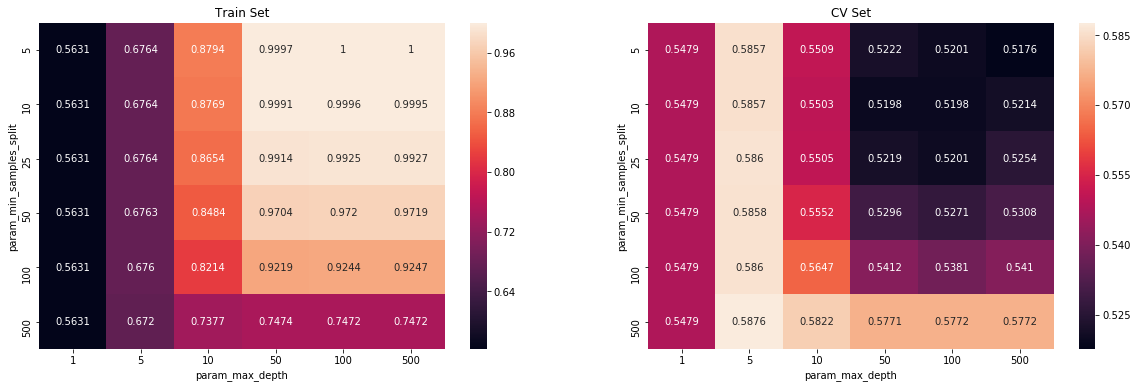

In [77]:
from sklearn.model_selection import GridSearchCV
max_scores = pd.DataFrame(sd.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]

fig, ax = plt.subplots(1,2, figsize=(20,6))

sns.heatmap(max_scores.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores.mean_test_score, annot = True, fmt='.4g', ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('CV Set')

plt.show()

#### HyperParameter tuning

### max_depth

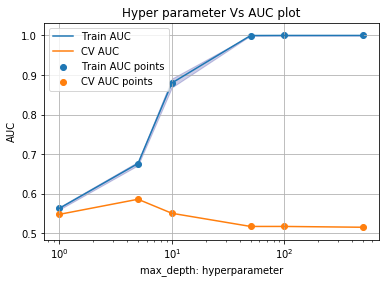

In [78]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

clf=tree.DecisionTreeClassifier(class_weight = 'balanced')

parameters= {'max_depth': [1, 5, 10, 50,100, 500]}
sd = GridSearchCV(clf, parameters, cv=5, scoring='roc_auc',return_train_score=True)
sd.fit(x_tr_tfidf_w2v, y_train)


train_auc= sd.cv_results_['mean_train_score']
train_auc_std= sd.cv_results_['std_train_score']
cv_auc = sd.cv_results_['mean_test_score'] 
cv_auc_std= sd.cv_results_['std_test_score']

plt.plot(parameters['max_depth'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['max_depth'], train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters['max_depth'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters['max_depth'], train_auc, label='Train AUC points')
plt.scatter(parameters['max_depth'], cv_auc, label='CV AUC points')
plt.xscale('log')


plt.legend()
plt.xlabel("max_depth: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()


### min_samples_split

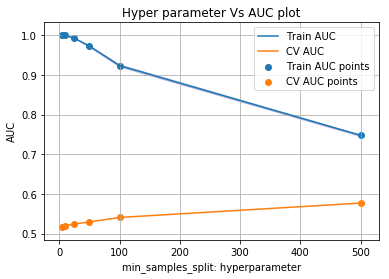

In [79]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

clf=tree.DecisionTreeClassifier(class_weight = 'balanced')

parameters= {'min_samples_split': [5, 10,25, 50, 100, 500]}
sd = GridSearchCV(clf, parameters, cv=5, scoring='roc_auc',return_train_score=True)
sd.fit(x_tr_tfidf_w2v, y_train)


train_auc= sd.cv_results_['mean_train_score']
train_auc_std= sd.cv_results_['std_train_score']
cv_auc = sd.cv_results_['mean_test_score'] 
cv_auc_std= sd.cv_results_['std_test_score']

plt.plot(parameters['min_samples_split'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['min_samples_split'], train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters['min_samples_split'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters['min_samples_split'], train_auc, label='Train AUC points')
plt.scatter(parameters['min_samples_split'], cv_auc, label='CV AUC points')



plt.legend()
plt.xlabel("min_samples_split: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()


#### Testing the performance of the model on test data, plotting ROC Curves

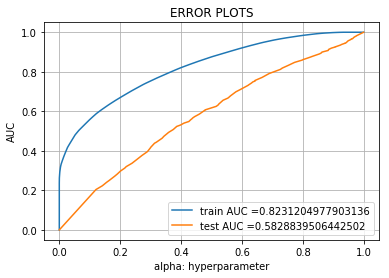

In [85]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


dt = tree.DecisionTreeClassifier(max_depth=100, min_samples_split=  500)
dt.fit(x_tr_tfidf_w2v, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(dt,x_tr_tfidf_w2v )    
y_test_pred = batch_predict(dt, x_test_tfidf_w2v)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

#### plotting confusion matrix

In [86]:
## TRAIN
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.24999997915340996 for threshold 0.737
[[ 1731  1732]
 [ 2366 16616]]


In [87]:
conf_matr_df_train = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds,train_fpr, train_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.24999997915340996 for threshold 0.737


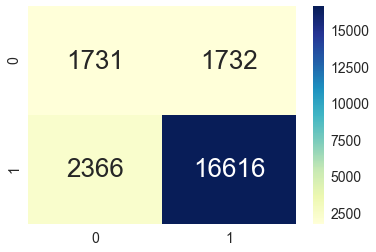

In [88]:
## Heatmaps -> https://likegeeks.com/seaborn-heatmap-tutorial/
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train, annot=True,annot_kws={"size": 26}, fmt='g',cmap="YlGnBu")

#### confusion matrix for test

In [89]:
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24975316702138622 for threshold 0.832
[[1233 1313]
 [5231 8723]]


the maximum value of tpr*(1-fpr) 0.24975316702138622 for threshold 0.832


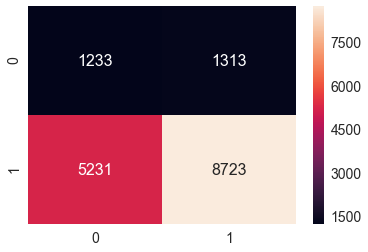

In [90]:
conf_matr_df_test = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test, annot=True,annot_kws={"size": 16}, fmt='g')

### False positive points

In [91]:
print( len( y_test_pred ) )
ytest = list( y_test )
len( ytest )

16500


16500

In [92]:
# Claculating indexes of False Positive points
ind = []
for i in range( 0, 5000 ):
    
    if y_test_pred[i] == 0 and ytest[i] == 1:
        
        ind.append(i)

In [93]:
print( ind )
len( ind )

[172, 248, 272, 321, 416, 426, 436, 439, 668, 681, 747, 844, 858, 890, 1090, 1103, 1239, 1447, 1602, 1605, 1652, 1698, 2048, 2129, 2178, 2179, 2245, 2443, 2444, 2462, 2500, 2618, 2669, 2701, 2759, 2836, 2932, 2942, 2968, 3027, 3059, 3087, 3191, 3222, 3243, 3291, 3300, 3422, 3435, 3463, 3658, 3705, 3723, 3783, 3788, 3835, 3848, 3918, 3942, 3974, 4110, 4179, 4239, 4325, 4348, 4409, 4414, 4443, 4460, 4485, 4504, 4592, 4597, 4709, 4774]


75

In [94]:
essay = ""
for i in ind:
    temp = project_data['essay'][i]
    essay += temp


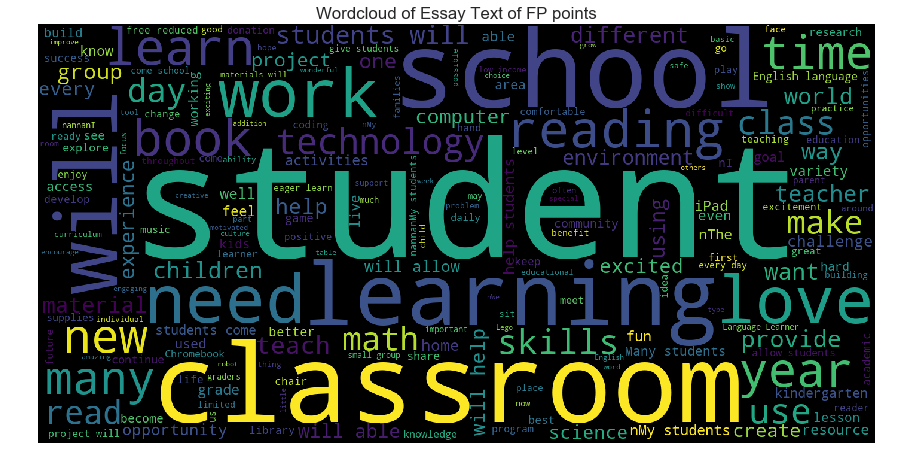

In [95]:
from wordcloud import WordCloud

# Create and generate a word cloud image:
wordcloud = WordCloud( background_color='black', width=1400, height=700 ).generate( essay )

# Display the generated image:
fig = plt.figure( figsize=(15,20) )
plt.imshow( wordcloud )
plt.title('Wordcloud of Essay Text of FP points')
plt.axis('off')
plt.show()

#### box plot of price of false postive data points

In [119]:
# appending price feat with false positive indexes
price = []

for i in ind:
    price.append( project_data['price'][i] )

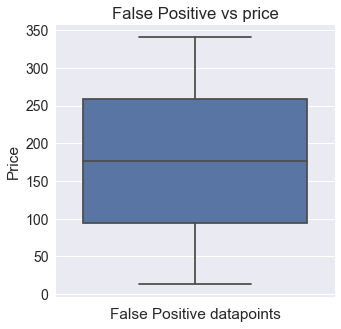

In [120]:
import seaborn as sns

plt.figure( figsize =(5,5) )
#plt.plot( ind, price )
sns.boxplot( y = price )
plt.xlabel('False Positive datapoints')
plt.ylabel('Price')
plt.title('False Positive vs price')
plt.show()


### pdf of teacher_number_of_previously_posted_projects 'false positive data points'

In [121]:
tnopp = []

for i in ind:
    tnopp.append( project_data['teacher_number_of_previously_posted_projects'][i] )

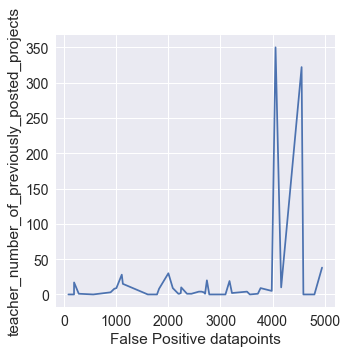

In [122]:
plt.figure( figsize =(5,5) )

plt.plot( ind, tnopp )

plt.xlabel('False Positive datapoints')
plt.ylabel('teacher_number_of_previously_posted_projects')

plt.show()

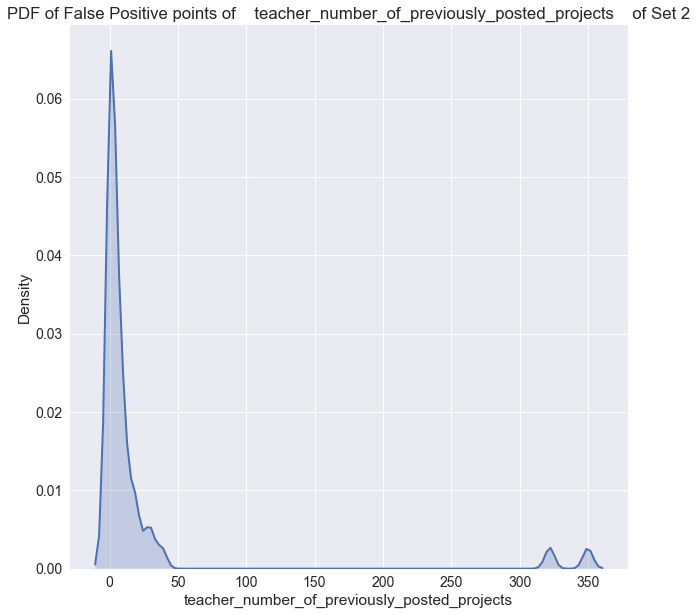

In [123]:
plt.figure( figsize =(10,10) )

sns.distplot( tnopp, hist = False, kde = True, kde_kws ={ 'linewidth' : 2, 'shade' : True } )

plt.title('PDF of False Positive points of    teacher_number_of_previously_posted_projects    of Set 2')
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.ylabel('Density')
plt.show()

#### Selecting Tfidf of 5k  features which are having non-zero feature importance

In [85]:
#  creating the matrix 
x_tr_tfidf=hstack((categorical_tr,numerical_tr,X_train_essay_tfidf,X_train_title_tfidf)).tocsr()
x_cv_tfidf=hstack((categorical_cv,numerical_cv,X_cv_essay_tfidf,X_cv_title_tfidf)).tocsr()
x_test_tfidf=hstack((categorical_test,numerical_test,X_test_essay_tfidf,X_test_title_tfidf)).tocsr()

print('final matrix')
print(x_tr_tfidf.shape,   y_train.shape)
print(x_cv_tfidf.shape,   y_cv.shape)
print(x_test_tfidf.shape, y_test.shape)

final matrix
(22445, 7753) (22445,)
(11055, 7753) (11055,)
(16500, 7753) (16500,)


In [86]:
clf=tree.DecisionTreeClassifier(class_weight = 'balanced')


clf.fit(x_tr_tfidf, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [80]:
#https://datascience.stackexchange.com/questions/6683/feature-selection-using-feature-importances-in-random-forests-with-scikit-learn

def selectKImportance(model, X, k=5):
    return X[:,model.feature_importances_.argsort()[::-1][:k]]

In [87]:
X_train1 = selectKImportance(clf, x_tr_tfidf, 5000)
X_test1 = selectKImportance(clf, x_test_tfidf, 5000)

In [89]:
print(X_train1.shape)
print(X_test1.shape)

(22445, 5000)
(16500, 5000)


### Applying Logistic Regression Model

#### Hyper Parameter tuning

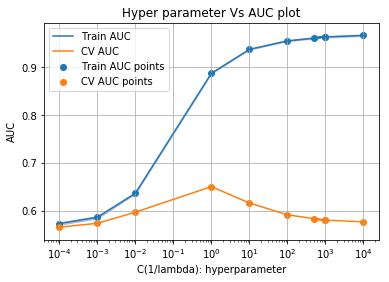

In [91]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
#from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV


clf=LogisticRegression(class_weight='balanced')
parameters ={'C':[10**-4, 10**-3,10**-2,1,10,100,1000,500,1000,10000]}
sd = GridSearchCV(clf, parameters, cv=5, scoring='roc_auc',return_train_score=True)
sd.fit(X_train1, y_train)



train_auc= sd.cv_results_['mean_train_score']
train_auc_std= sd.cv_results_['std_train_score']
cv_auc = sd.cv_results_['mean_test_score'] 
cv_auc_std= sd.cv_results_['std_test_score']

plt.plot(parameters['C'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['C'], train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters['C'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters['C'], train_auc, label='Train AUC points')
plt.scatter(parameters['C'], cv_auc, label='CV AUC points')
plt.xscale('log') 



plt.legend()
plt.xlabel("C(1/lambda): hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()



### Testing the performance of the model on test data, plotting ROC Curves

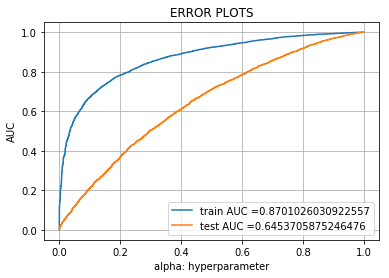

In [96]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


mnb = LogisticRegression(C=1,class_weight='balanced')
mnb.fit(X_train1, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(mnb, X_train1)    
y_test_pred = batch_predict(mnb, X_test1)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

#### confusion matrix of train

In [97]:
## TRAIN
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.24999997915340996 for threshold 0.355
[[ 1731  1732]
 [ 1450 17532]]


In [98]:
conf_matr_df_train = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds,train_fpr, train_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.24999997915340996 for threshold 0.355


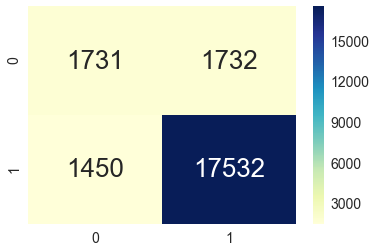

In [99]:
## Heatmaps -> https://likegeeks.com/seaborn-heatmap-tutorial/
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train, annot=True,annot_kws={"size": 26}, fmt='g',cmap="YlGnBu")

#### confusion matrix for test

In [100]:
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.25 for threshold 0.396
[[  780  1766]
 [ 2052 11902]]


the maximum value of tpr*(1-fpr) 0.25 for threshold 0.396


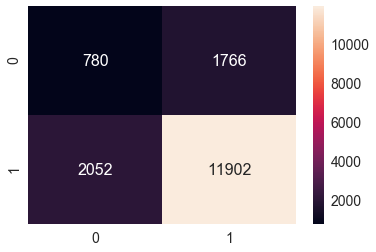

In [101]:
conf_matr_df_test = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test, annot=True,annot_kws={"size": 16}, fmt='g')

### Summary

In [134]:
#http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
    
x = PrettyTable()
x.field_names = ["Vectorizer",     "Hyperparameter",                             "trainAUC", "test AUC" ]
x.add_row(["TFIDF",               'max_depth=50 and min_samples_split=100',      "0.8011",  "0.5446" ])
x.add_row(["Tfidfw2v",           'max_depth=50 and min_samples_split =500',      "0.7755", "0.5545"])
x.add_row(["5k feat" ,                    '1',                                     "0.8701", "0.6453" ])

print(x)

+------------+-----------------------------------------+----------+----------+
| Vectorizer |              Hyperparameter             | trainAUC | test AUC |
+------------+-----------------------------------------+----------+----------+
|   TFIDF    |  max_depth=50 and min_samples_split=100 |  0.8011  |  0.5446  |
|  Tfidfw2v  | max_depth=50 and min_samples_split =500 |  0.7755  |  0.5545  |
|  5k feat   |                    1                    |  0.8701  |  0.6453  |
+------------+-----------------------------------------+----------+----------+
